# FastRCNN Object Proposal Investigation

In this notebook, we explore the built in region proposal network in VGGnet and Fast RCNN.

In [1]:
# Setup our notebook environment
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

from IPython.display import HTML

## Fast RCNN 

We will see object detections given by Fast RCNN.

In [2]:
# Common Python Library
lib_directory = "/raid/baldwin/code/people-tracking/lib"

# Models Directory
model_directory = "/raid/baldwin/code/people-tracking/models/"

import sys

# Current Path Information
previous_path_length = len(sys.path)

sys.path.insert(0, lib_directory)
sys.path.insert(0, model_directory)

# New Path Information
new_path_length = len(sys.path)

print("Path length: {}->{}".format(previous_path_length, new_path_length))

Path length: 10->12


In [3]:
from common.abstract.data import Image, Color
from human.classifier import HumanPresenceClassifier, CLASSES

HumanPresenceClassifier.saver_state_file = "/raid/baldwin/code/people-tracking/models/human/VGGnet_fast_rcnn_iter_150000.ckpt"

classifier = HumanPresenceClassifier()

person_class_index = CLASSES.index('person')

Tensor("Placeholder:0", shape=(?, ?, ?, 3), dtype=float32)
Tensor("conv5_3/Relu:0", shape=(?, ?, ?, 512), dtype=float32)
Tensor("rpn_conv/3x3/Relu:0", shape=(?, ?, ?, 512), dtype=float32)
Tensor("rpn_cls_score/BiasAdd:0", shape=(?, ?, ?, 18), dtype=float32)
Tensor("rpn_cls_prob:0", shape=(?, ?, ?, ?), dtype=float32)
Tensor("Reshape_2:0", shape=(?, ?, ?, 18), dtype=float32)
Tensor("rpn_bbox_pred/BiasAdd:0", shape=(?, ?, ?, 36), dtype=float32)
Tensor("Placeholder_1:0", shape=(?, 3), dtype=float32)
Tensor("conv5_3/Relu:0", shape=(?, ?, ?, 512), dtype=float32)
Tensor("rois:0", shape=(?, 5), dtype=float32)
[<tf.Tensor 'conv5_3/Relu:0' shape=(?, ?, ?, 512) dtype=float32>, <tf.Tensor 'rois:0' shape=(?, 5) dtype=float32>]
Tensor("fc7/fc7:0", shape=(?, 4096), dtype=float32)
INFO:tensorflow:Restoring parameters from /raid/baldwin/code/people-tracking/models/human/VGGnet_fast_rcnn_iter_150000.ckpt


In [4]:
# Helpful utilities

from common.utils.image_manipulation import draw_spatial_results_on_image

def annotate_image(image, classifications, only_persons=False):
    if only_persons:
        spatial_results = classifications.get('person', list())
        image = draw_spatial_results_on_image(image, spatial_results=spatial_results)
        return image
    
    for class_label in classifications.keys():
        spatial_results = classifications.get(class_label, list())
        image = draw_spatial_results_on_image(image, spatial_results=spatial_results)
    return image

def classify_and_annotate_image(image, only_persons=True):
    image_classifications = classifier.classify(image)
    return annotate_image(image, image_classifications, only_persons)

def show_image(image, plot_title=''):
    plt.figure()
    plt.title(plot_title)
    plt.imshow(image.get_np_array())

In [5]:
image_path = 'samples/hugging.jpg'

Image width 640 height 426
Person count: 1


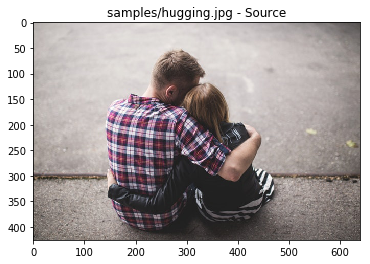

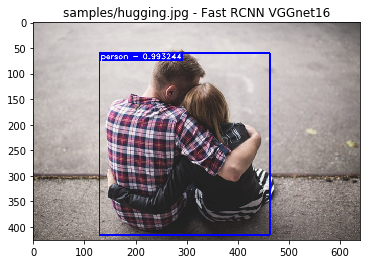

In [6]:
image = Image.from_file(image_path)
print "Image width {} height {}".format(image.width(), image.height())

show_image(image, '{} - Source'.format(image_path))

classifications = classifier.classify(image)
show_image(annotate_image(image, classifications, only_persons=True), '{} - Fast RCNN VGGnet16'.format(image_path))
print "Person count: {}".format(len(classifications.get('person')))

In [7]:
# Let's extract the data before post-processing
def get_person_boxes_and_scores(image):
    object_proposals = classifier.detect_object_proposals(image.cv2_encode())
    boxes = object_proposals.get_boxes_for_class_index(person_class_index)
    scores = object_proposals.get_scores_for_class_index(person_class_index)
    return boxes, scores

boxes, scores = get_person_boxes_and_scores(image)
print "Boxes: {}, Scores: {}".format(boxes.shape, scores.shape)

Boxes: (193, 4), Scores: (193,)


Flattened: (193, 5)


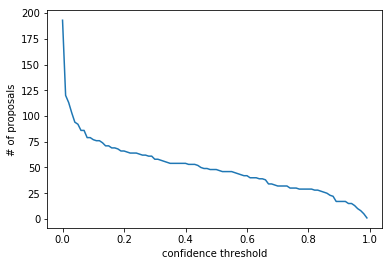

In [8]:
flattened_vector = np.hstack((boxes, scores[:, np.newaxis])).astype(np.float32)

print "Flattened: {}".format(flattened_vector.shape)

def threshold_proposals(flattened, threshold=0.85):
    indices_above_threshold = np.where(flattened[:, -1] >= threshold)[0]
    reduced_proposals = flattened_vector[indices_above_threshold]
    return reduced_proposals

# Let's graph the # of proposals versus threshold limit
plt.figure()
thresholds = [i for i in np.arange(0.0, 1.0, 0.01)]
plt.plot(thresholds, [threshold_proposals(flattened_vector, threshold).shape[0] for threshold in thresholds])
plt.ylabel('# of proposals')
plt.xlabel('confidence threshold')
plt.show()

In [9]:
from common.abstract.machine_learning.result.objects import SpatialResult

from common.utils.data_manipulation import parse_bounding_box
from common.abstract.cartesian import Coordinate
from common.abstract.shapes import Rectangle

# Let's draw all of these proposals
def proposals_to_spatial_results(proposals, label='person'):
    results = list()
    for proposal in proposals:
        x_top, y_top, x_bottom, y_bottom = proposal[:4]
        score = proposal[-1]
        
        x_top, y_top, width, height = parse_bounding_box(x_top, y_top, x_bottom, y_bottom)
        shape = Rectangle(width=width, height=height)
        origin = Coordinate(x_top, y_top)
        spatial_result = SpatialResult(label=label, score=score, shape=shape, origin=origin)
        
        results.append(spatial_result)
    return results

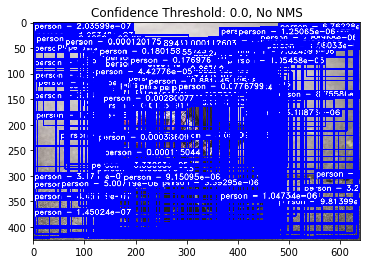

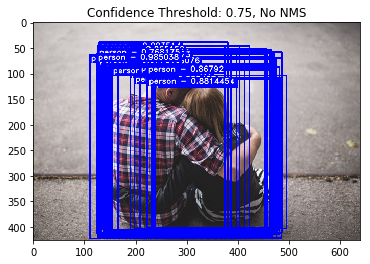

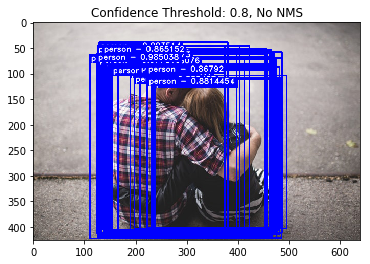

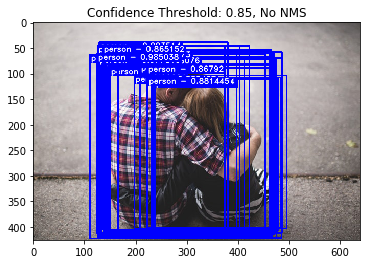

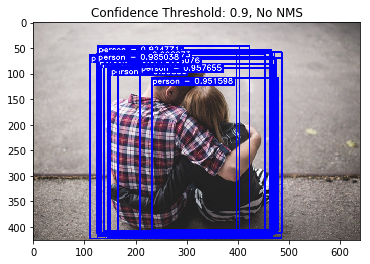

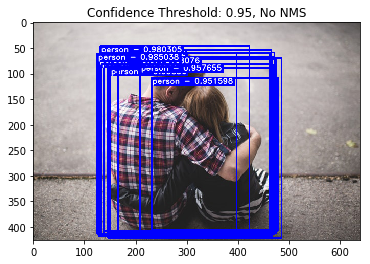

In [10]:
for threshold in [0.00, 0.75, 0.80, 0.85, 0.90, 0.95]:
    proposals = threshold_proposals(flattened_vector, threshold=threshold)
    spatial_results = proposals_to_spatial_results(proposals)
    show_image(draw_spatial_results_on_image(image, spatial_results=spatial_results), 'Confidence Threshold: {}, No NMS'.format(threshold))

# Clustering object proposals

We will use a unsupervised learning technique known as clustering to identify which cluster each group of bounding boxes belong to.

Proposals: (17, 5), Boxes: (17, 4), Scores: (17,)
Centers: (17, 2)


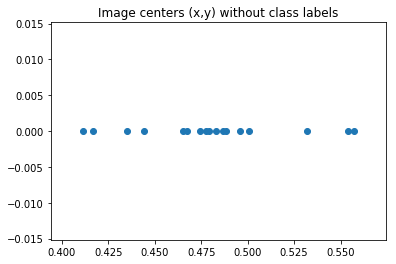

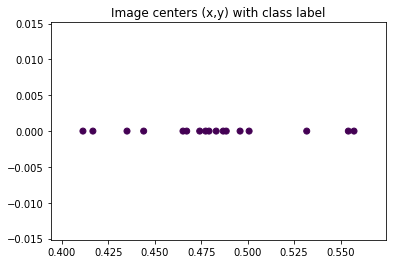

Proposals: (17, 6), # of classes: 1


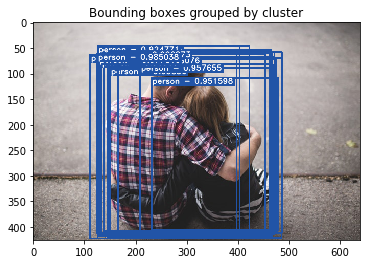

In [11]:
# Calculate the center of each proposal
confidence_threshold = 0.90
proposals = threshold_proposals(flattened_vector, threshold=confidence_threshold)
boxes, scores = proposals[:,0:4], proposals[:,4]
print "Proposals: {}, Boxes: {}, Scores: {}".format(proposals.shape, boxes.shape, scores.shape)

x_top, y_top, x_bottom, y_bottom = (boxes[:,i] for i in range(4))

# Do some feature scaling
centers = np.array([((x_bottom + x_top)/ 2 ) / image.width(), np.zeros(len(boxes))]).T
print "Centers: {}".format(centers.shape)

plt.figure()
plt.scatter(centers[:,0], centers[:,1])
plt.title('Image centers (x,y) without class labels')
plt.show()

from sklearn.cluster import DBSCAN
clusterer = DBSCAN(min_samples=2, eps=len(centers))
y = clusterer.fit_predict(centers)

plt.figure()
plt.scatter(centers[:,0], centers[:,1], c=y)
plt.title('Image centers (x,y) with class label')
plt.show()

# new proposals
new_proposals = np.hstack((proposals, y[:, np.newaxis]))
classes = np.unique(y)
print "Proposals: {}, # of classes: {}".format(new_proposals.shape, len(classes))

# Let's draw the two regions on our image!
cls_image = image
for cls in classes:
    random_color = Color(*[np.random.randint(0, 255) for i in range(3)])
    spatial_results = proposals_to_spatial_results(proposals[np.where(y == cls)[0]])
    cls_image = draw_spatial_results_on_image(cls_image, spatial_results=spatial_results, color=random_color)

show_image(cls_image, 'Bounding boxes grouped by cluster')